# Importing Data & Cleaning

In [165]:
import pandas as pd, re
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import glob
import os
import numpy as np
import math
import seaborn as sb
import geocoder
import requests
import time
import folium
from folium.plugins import HeatMap, HeatMapWithTime

<b> Importing PSNI street crime data from 08-2015 to 05-2018 and displaying the first five rows </b>

In [2]:
src_dir ='data/PSNI_StreetCrime_1Year'
psni_crime_data = pd.DataFrame()
list_ = []
i = 0
for root, dirs, files in os.walk(src_dir):
    allFiles = glob.glob(root + "/*.csv")
    for file in allFiles:
        year_df = pd.read_csv(file,index_col=None, header=0)
        list_.append(year_df)
        psni_crime_data = pd.concat(list_)
psni_crime_data.head()

,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Context
0,NaN,2015-08,Police Service of Northern Ireland,Police Service of Northern Ireland,-7.378949,54.717334,On or near Dublin Street,NaN,NaN,Anti-social behaviour,NaN,NaN
1,NaN,2015-08,Police Service of Northern Ireland,Police Service of Northern Ireland,-5.891082,54.222501,On or near Bracken Avenue,NaN,NaN,Anti-social behaviour,NaN,NaN
2,NaN,2015-08,Police Service of Northern Ireland,Police Service of Northern Ireland,-5.667276,54.663573,On or near High Street,NaN,NaN,Anti-social behaviour,NaN,NaN
3,NaN,2015-08,Police Service of Northern Ireland,Police Service of Northern Ireland,-5.962330,54.587243,On or near Rodney Parade,NaN,NaN,Anti-social behaviour,NaN,NaN
4,NaN,2015-08,Police Service of Northern Ireland,Police Service of Northern Ireland,-5.894063,54.590423,On or near Brenda Street,NaN,NaN,Anti-social behaviour,NaN,NaN


<b> Let's look at the data frame from a high level and identify the data type and stored data in the columns  </b>

In [3]:
psni_crime_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 445745 entries, 0 to 13728
Data columns (total 12 columns):
Crime ID                 274726 non-null object
Month                    445745 non-null object
Reported by              445745 non-null object
Falls within             445745 non-null object
Longitude                443370 non-null float64
Latitude                 443370 non-null float64
Location                 445745 non-null object
LSOA code                0 non-null float64
LSOA name                0 non-null float64
Crime type               445745 non-null object
Last outcome category    0 non-null float64
Context                  0 non-null float64
dtypes: float64(6), object(6)
memory usage: 44.2+ MB


<b> There are a number of fields that are redundant, containing all null values. Let's drop them from the table.  </b>

In [4]:
psni_crime_data = psni_crime_data.drop(['LSOA code', 'LSOA name', 'Last outcome category', 'Context'], axis=1)

In [5]:
psni_crime_data.describe(include='all')

,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,Crime type
count,274726,445745,445745,445745,443370.000000,443370.000000,445745,445745
unique,11728,34,1,1,NaN,NaN,14872,14
top,d0116055d2f40fa25a81c663a3d5ac45d36eec7737990e...,2015-10,Police Service of Northern Ireland,Police Service of Northern Ireland,NaN,NaN,On or near,Anti-social behaviour
freq,34,15444,445745,445745,NaN,NaN,61638,171019
mean,NaN,NaN,NaN,NaN,-6.268281,54.620995,NaN,NaN
std,NaN,NaN,NaN,NaN,0.527199,0.227856,NaN,NaN
min,NaN,NaN,NaN,NaN,-8.148313,54.026858,NaN,NaN
25%,NaN,NaN,NaN,NaN,-6.512727,54.511284,NaN,NaN
50%,NaN,NaN,NaN,NaN,-6.011100,54.597057,NaN,NaN
75%,NaN,NaN,NaN,NaN,-5.924801,54.697173,NaN,NaN


<b> Crime ID is not shared by all the rows. According to the official police API (https://data.police.uk/docs/method/crime-street/), this is used as an ID for the API and is not a police identifier.  Let's investigate this ID further and decide whether it is valuable to have in the table. </b>

In [6]:
num_unique_crime_ids = psni_crime_data['Crime ID'].nunique()
print(f"Number of unique crime ids: {num_unique_crime_ids}")

psni_crime_data_crimetype = psni_crime_data.groupby('Crime type')['Crime ID'].count()
psni_crime_data_crimetype

Number of unique crime ids: 11728


Crime type
Anti-social behaviour                0
Bicycle theft                     2141
Burglary                         20368
Criminal damage and arson        52336
Drugs                            16483
Other crime                       7472
Other theft                      37313
Possession of weapons             2701
Public order                      3334
Robbery                           1732
Shoplifting                      17389
Theft from the person             1253
Vehicle crime                    11743
Violence and sexual offences    100461
Name: Crime ID, dtype: int64

<b> Anti social behaviour does not have any Crime IDs associated with them. As Crime ID is not unique this makes me suspect there could be duplicates of the same crime in the table. I'm going to investigate this by finding rows with the same Crime ID, Month, Longitude, Latitude, Location and Crime Type </b>

In [7]:
grouped_psni_crime_data = psni_crime_data.fillna(-1).groupby(['Crime ID','Month', 'Longitude','Latitude', 'Location', 'Crime type']).size().reset_index(name='counts')

In [8]:
num_duplicate_rows = grouped_psni_crime_data[grouped_psni_crime_data.counts > 1].counts.sum()
percent_duplicate_rows = "{:.1%}".format(num_duplicate_rows/len(psni_crime_data))
print(f"{percent_duplicate_rows}")

16.3%


<b> 16.3% of rows could be potentially duplicate. I will drop Crime ID as it is not an effective unique identifier for the rows and has no use interacting with the Police API.</b>

In [9]:
psni_crime_data = psni_crime_data.drop(['Crime ID'], axis=1)

<b> 'Reported by' and 'Falls within' columns can be dropped as in all entries they are both set to 'Police Service of Northern Ireland'</b>

In [10]:
print(psni_crime_data['Reported by'].nunique())
print(psni_crime_data['Falls within'].nunique())
psni_crime_data = psni_crime_data.drop(['Reported by', 'Falls within'], axis=1)

1
1


<b> There is NaN float values in the longitude and latitude. Let's investigate this further. </b>

In [11]:
psni_crime_data[psni_crime_data['Longitude'].isnull() | psni_crime_data['Longitude'].isnull()].head()


,Month,Longitude,Latitude,Location,Crime type
225,2015-08,NaN,NaN,No Location,Anti-social behaviour
3812,2015-08,NaN,NaN,No Location,Anti-social behaviour
5713,2015-08,NaN,NaN,No Location,Bicycle theft
5732,2015-08,NaN,NaN,No Location,Bicycle theft
6223,2015-08,NaN,NaN,No Location,Burglary


<b> I'm going to verify that No Location value in Location has a direct relationship with Longitude and Latitude </b>

In [12]:
psni_crime_data[(psni_crime_data['Location'] == 'No Location') & ~(psni_crime_data['Longitude'].isnull() & psni_crime_data['Longitude'].isnull())].head()

,Month,Longitude,Latitude,Location,Crime type


<b> Let's add a binary column that is 1 if the location associated and 0 if it does not not. This will make excluding these datasets more manageable when geographing the crimes. </b>

In [13]:
def has_location(row):
    if (math.isnan(row['Longitude']) or math.isnan(row['Latitude']) or row['Location'] == 'No Location'):
        return False
    else:
        return True

psni_crime_data['Has_Location'] = psni_crime_data.apply(lambda row: has_location (row),axis=1)

In [14]:
psni_crime_data.dtypes

Month            object
Longitude       float64
Latitude        float64
Location         object
Crime type       object
Has_Location       bool
dtype: object

<b> The month column data is presented in the format yyyy-mm. This can be converted to datetime split up into more columns to allow for more information to be derived. </b>

In [15]:
psni_crime_data['Date'] = pd.to_datetime(psni_crime_data['Month'], format='%Y-%m')
psni_crime_data = psni_crime_data.drop(['Month'], axis=1)

In [16]:
def add_datepart(df, fldname, drop=True, time=False):
    """add_datepart converts a column of df from a datetime64 to many columns containing
    the information from the date. This applies changes inplace.
    Parameters:
    -----------
    df: A pandas data frame. df gain several new columns.
    fldname: A string that is the name of the date column you wish to expand.
        If it is not a datetime64 series, it will be converted to one with pd.to_datetime.
    drop: If true then the original date column will be removed.
    time: If true time features: Hour, Minute, Second will be added.
    Examples:
    ---------
    >>> df = pd.DataFrame({ 'A' : pd.to_datetime(['3/11/2000', '3/12/2000', '3/13/2000'], infer_datetime_format=False) })
    >>> df
        A
    0   2000-03-11
    1   2000-03-12
    2   2000-03-13
    >>> add_datepart(df, 'A')
    >>> df
        AYear AMonth AWeek ADay ADayofweek ADayofyear AIs_month_end AIs_month_start AIs_quarter_end AIs_quarter_start AIs_year_end AIs_year_start AElapsed
    0   2000  3      10    11   5          71         False         False           False           False             False        False          952732800
    1   2000  3      10    12   6          72         False         False           False           False             False        False          952819200
    2   2000  3      11    13   0          73         False         False           False           False             False        False          952905600
    """
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Quarter']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    if drop: df.drop(fldname, axis=1, inplace=True)
        

In [17]:
add_datepart(psni_crime_data, 'Date')

In [18]:
psni_crime_data.dtypes

Longitude       float64
Latitude        float64
Location         object
Crime type       object
Has_Location       bool
Year              int64
Month             int64
Week              int64
Quarter           int64
dtype: object

<b>Location has the streets listed with 'On or near' preceding them. This can be formatted for better location processing.</b>

In [19]:
def format_street(row):
    formattedstreet = row['Location']
    formattedstreet = formattedstreet.replace('On or near', '')
    formattedstreet = formattedstreet.strip()
    return formattedstreet.lower()
    

psni_crime_data['Location'] = psni_crime_data.apply(lambda row: format_street(row), axis=1)

In [20]:
psni_crime_data[psni_crime_data['Location'] == 'dublin street'].head(5)

,Longitude,Latitude,Location,Crime type,Has_Location,Year,Month,Week,Quarter
0,-7.378949,54.717334,dublin street,Anti-social behaviour,True,2015,8,31,3
3019,-7.378949,54.717334,dublin street,Anti-social behaviour,True,2015,8,31,3
6544,-7.378949,54.717334,dublin street,Criminal damage and arson,True,2015,8,31,3
2606,-7.380017,54.713413,dublin street,Anti-social behaviour,True,2015,9,36,3
877,-7.378949,54.717334,dublin street,Anti-social behaviour,True,2015,10,40,4


In [21]:
psni_crime_data.dtypes
psni_crime_data['Crime type'] = psni_crime_data['Crime type'].astype('category')
psni_crime_data['Location'] = psni_crime_data['Location'].astype('category')

#psni_crime_data.describe()
#psni_crime_data[(psni_crime_data.Has_Location) == True & (psni_crime_data.Location != '')]
#sb.heatmap(psni_crime_data[psni_crime_data.Has_Location == True])

In [22]:
psni_crime_data.dtypes

Longitude        float64
Latitude         float64
Location        category
Crime type      category
Has_Location        bool
Year               int64
Month              int64
Week               int64
Quarter            int64
dtype: object

<b> I am now content the data has been cleaned. </b>

# Visualising some data

<b> I am going to create a chart showing the crimes per month and year to see if there is any general trend in crime over a time period. </b>

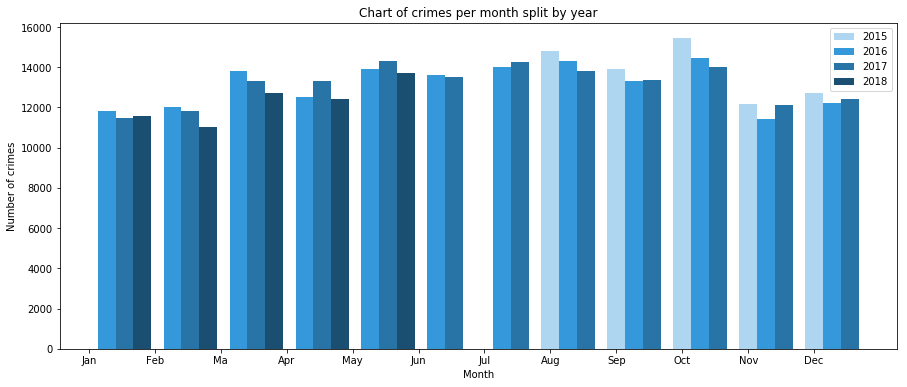

In [23]:
psni_crime_data_grouped_month_year = psni_crime_data.groupby(['Month', 'Year']).size().reset_index(name='counts')
width = 0.27

fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(111)

yvals2015 = psni_crime_data_grouped_month_year[psni_crime_data_grouped_month_year.Year == 2015].counts
xvals2015 = psni_crime_data_grouped_month_year[psni_crime_data_grouped_month_year.Year == 2015].Month
rects2015 = ax.bar(xvals2015, yvals2015, width, color='#AED6F1')

yvals2016 = psni_crime_data_grouped_month_year[psni_crime_data_grouped_month_year.Year == 2016].counts
xvals2016 = psni_crime_data_grouped_month_year[psni_crime_data_grouped_month_year.Year == 2016].Month
rects2016 = ax.bar(xvals2016+width, yvals2016, width, color='#3498DB')

yvals2017 = psni_crime_data_grouped_month_year[psni_crime_data_grouped_month_year.Year == 2017].counts
xvals2017 = psni_crime_data_grouped_month_year[psni_crime_data_grouped_month_year.Year == 2017].Month
rects2017 = ax.bar(xvals2017+width*2, yvals2017, width, color='#2874A6')

yvals2018 = psni_crime_data_grouped_month_year[psni_crime_data_grouped_month_year.Year == 2018].counts
xvals2018 = psni_crime_data_grouped_month_year[psni_crime_data_grouped_month_year.Year == 2018].Month
rects2018 = ax.bar(xvals2018+width*3, yvals2018, width, color='#1B4F72')

ax.set_ylabel('Number of crimes')
ax.set_xlabel('Month')
ax.set_xticks(np.arange(1, 13, step=1.0))
ax.set_xticklabels(('Jan', 'Feb', 'Ma', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'))
ax.legend([rects2015[0], rects2016[0], rects2017[0], rects2018[0]], ('2015', '2016', '2017', '2018'))

plt.title("Chart of crimes per month split by year")

plt.show()

<b> Across the 4 years there seems to be a general decrease in total crimes in the winter months (January, February) and a peak in October </b>

<b> I am going to group the time specific columns to see if there is any general observations I can gather from the month, year and quarter of crime. The data ranges from 2015-08 to 2018-05 so I am going to choose 2016-01 to 2017-12 as the range to avoid data being skewed for months with more data. I'm going to look at a month and quarter level to see if there's any clear differences in times of the year and the number of crimes ocurring. </b>

In [24]:
psni_crime_data = psni_crime_data.reset_index()
psni_crime_data_ranged = psni_crime_data.drop(psni_crime_data[(psni_crime_data['Year'] == 2015) \
                                                              | ((psni_crime_data['Year'] == 2018))].index)
psni_crime_data_grouped_month = psni_crime_data_ranged.groupby('Month').size().reset_index(name='counts')
psni_crime_data_grouped_year = psni_crime_data_ranged.groupby('Year').size().reset_index(name='counts')
psni_crime_data_grouped_quarter = psni_crime_data_ranged.groupby('Quarter').size().reset_index(name='counts')

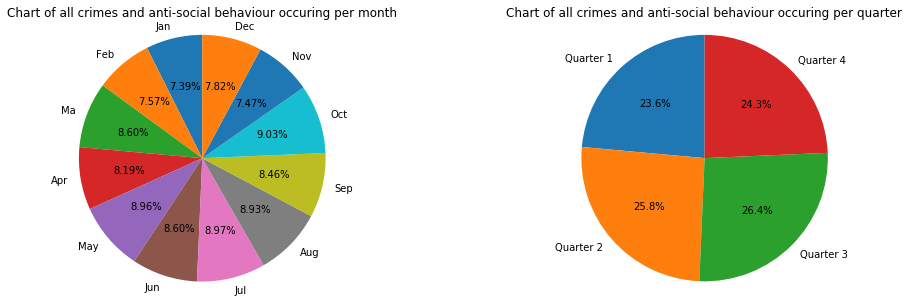

In [25]:
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.pie(psni_crime_data_grouped_month['counts'], labels = ('Jan', 'Feb', 'Ma', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'), \
        autopct='%1.2f%%', shadow=False, startangle=90)
plt.axis('equal')
plt.title("Chart of all crimes and anti-social behaviour occuring per month")

plt.subplot(1,2, 2)
plt.title("Chart of all crimes and anti-social behaviour occuring per quarter")
plt.pie(psni_crime_data_grouped_quarter['counts'], labels = ('Quarter 1', 'Quarter 2', 'Quarter 3', 'Quarter 4'), autopct='%1.1f%%', shadow=False, startangle=90)
plt.axis('equal')

plt.subplots_adjust(hspace=0.5)
plt.subplots_adjust(wspace=0.5)

<b> I observe that the most crimes occur in the month October and Quarter 3 and the least in the month January and Quarter 1. Let's take a look at comparing 2016 and 2017 and see if there is a trend in those periods.</b>

Text(0.5,1,'Chart of all crimes and anti-social behaviour occuring per month: 2016 versus 2017')

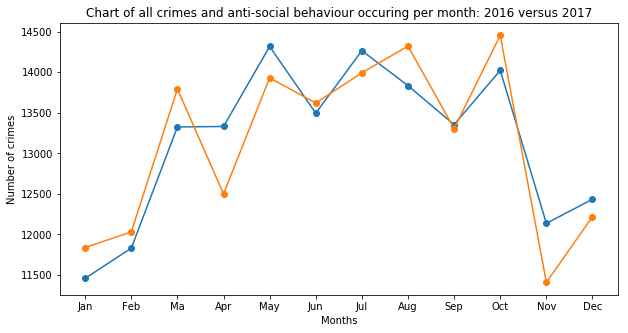

In [26]:
plt.figure(figsize=(10,5))

yvals2016 = psni_crime_data_grouped_month_year[psni_crime_data_grouped_month_year.Year == 2016].counts
xvals2016 = psni_crime_data_grouped_month_year[psni_crime_data_grouped_month_year.Year == 2016].Month
yvals2017 = psni_crime_data_grouped_month_year[psni_crime_data_grouped_month_year.Year == 2017].counts
xvals2017 = psni_crime_data_grouped_month_year[psni_crime_data_grouped_month_year.Year == 2017].Month
plt.plot(xvals2017, yvals2017, marker = 'o')
plt.plot(xvals2016, yvals2016, marker = 'o')
plt.xticks(np.arange(1, 13, step=1.0), ('Jan', 'Feb', 'Ma', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'))
plt.xlabel('Months')
plt.ylabel('Number of crimes')
plt.title("Chart of all crimes and anti-social behaviour occuring per month: 2016 versus 2017")

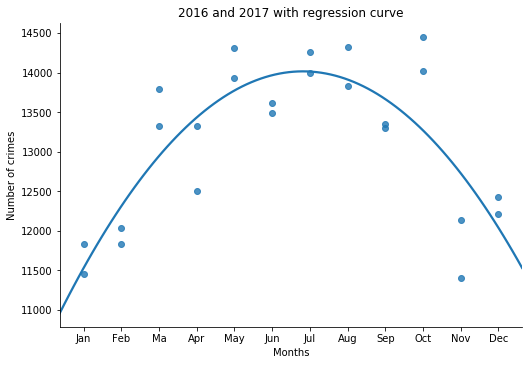

In [27]:
sb.lmplot('Month','counts',data=psni_crime_data_grouped_month_year[(psni_crime_data_grouped_month_year.Year == 2017) | (psni_crime_data_grouped_month_year.Year == 2016)], order=2, ci=None, height=5, aspect=1.5)
plt.xticks(np.arange(1, 13, step=1.0),('Jan', 'Feb', 'Ma', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'))
plt.xlabel('Months')
plt.ylabel('Number of crimes')
plt.title("2016 and 2017 with regression curve")
plt.show()

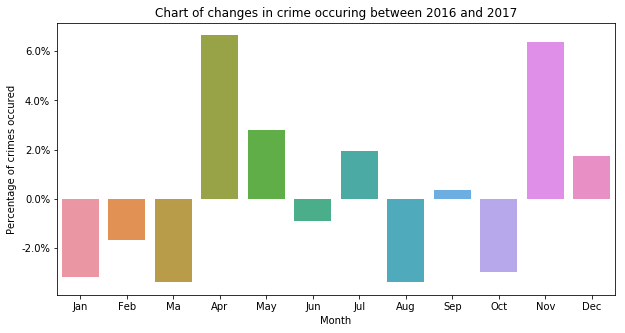

In [28]:
plt.figure(figsize=(10,5))
counts_per_month_2017 = psni_crime_data_grouped_month_year[psni_crime_data_grouped_month_year.Year == 2017].reset_index()
counts_per_month_2016 = psni_crime_data_grouped_month_year[psni_crime_data_grouped_month_year.Year == 2016].reset_index()

counts_per_month_difference = pd.DataFrame(columns=['Month', 'counts'])

dictMonth = {}
for index, row in counts_per_month_2017.iterrows():
    difference = (row['counts'] - counts_per_month_2016.iloc[index].counts)
    difference_percent = difference/(counts_per_month_2016.iloc[index].counts)*100
    dictMonth[str(index+1)] = difference_percent
    
difference_2016_2017 = pd.DataFrame.from_dict(dictMonth, orient='index')
difference_2016_2017.index = difference_2016_2017.index.astype(float)

ax = sb.barplot(difference_2016_2017.index, difference_2016_2017[0])
ax.set_ylabel('Percentage of crimes occured')
ax.set_xlabel('Month')
ax.set(xticks=(np.arange(0, 12, step=1.0)))
ax.set_xticklabels(('Jan', 'Feb', 'Ma', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'))
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.title("Chart of changes in crime occuring between 2016 and 2017")

plt.subplots_adjust(hspace=0.5)
plt.subplots_adjust(wspace=0.5)

<b> There is a higher occurence of crimes in summer months (June, July August) than in Winter Months (December, January, February). I am going to investigate the type of crimes being committed these months to see if there's a type of crime more or less prevelant in particular months. </b>

In [29]:
psni_crime_data_grouped_crime_type = psni_crime_data_ranged.groupby(['Month', 'Crime type']).size().reset_index(name='counts')
psni_crime_data_grouped_crime_type.head()

,Month,Crime type,counts
0,1,Anti-social behaviour,8366
1,1,Bicycle theft,87
2,1,Burglary,1228
3,1,Criminal damage and arson,2781
4,1,Drugs,890


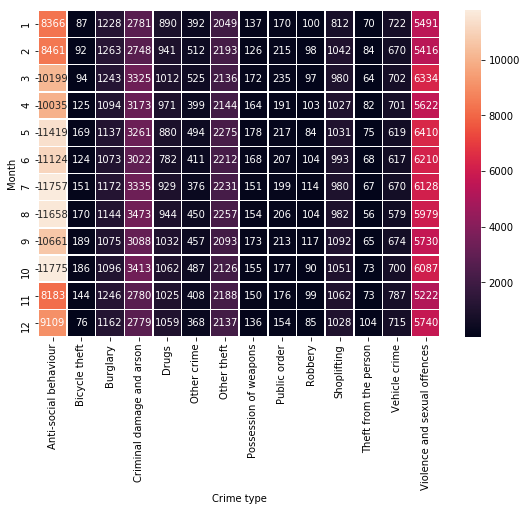

In [30]:
psni_crime_data_grouped_crime_type_pivot = psni_crime_data_grouped_crime_type.pivot('Month', 'Crime type', 'counts')
f, ax = plt.subplots(figsize=(9, 6))
sb.heatmap(psni_crime_data_grouped_crime_type_pivot, annot=True, fmt="d", linewidths=.5, ax=ax)

<b> This heat map is not very informative, with high counts of particular crimes and anti social behaviour not providing an insight into minor crimes frequency per month. Let's normalize the data frame. </b> 

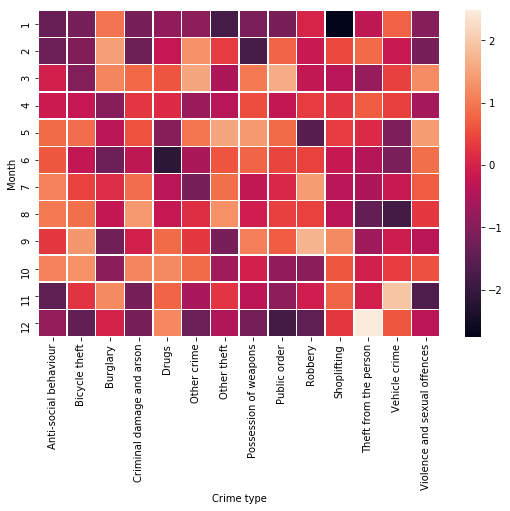

In [31]:
psni_crime_data_grouped_crime_type_pivot=(psni_crime_data_grouped_crime_type_pivot-psni_crime_data_grouped_crime_type_pivot.mean())/psni_crime_data_grouped_crime_type_pivot.std()
f, ax = plt.subplots(figsize=(9, 6))
sb.heatmap(psni_crime_data_grouped_crime_type_pivot, linewidths=.5, ax=ax)

<b> In the winter months (December, January and February): anti social behaviour, bicycle theft, criminal damage and arson is less prevelant than other crimes. Drug crime is more prevelant in summer months (June, July, August). Theft from the person is especially prevelant in December than other crimes. Vehicle crime is less prevelant in August than other crimes. </b>

<b> Crimes being committed in the winter that are less prevelant could be potentially be down to people's change in behaviour related to seasonal change. I am going load in meteorological data from the Met Office ( https://www.metoffice.gov.uk/climate/uk/summaries/datasets). I am going to use average sunshine per month and compare it with the number of crimes occuring. </b>

In [32]:
monthly_sunshine = pd.read_csv('data/MetOffice/Northern_Ireland_Sunshine.csv')
monthly_sunshine_2016_2017 = monthly_sunshine[(monthly_sunshine.Year == 2016) | (monthly_sunshine.Year == 2017)]
monthly_sunshine_2016_2017.head()

,Year,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,WIN,SPR,SUM,AUT,ANN
87,2016,34.3,71.6,113.7,149.8,218.1,130.4,108.7,128.8,94.8,89.2,76.0,39.1,136.4,481.6,367.9,260.0,1254.5
88,2017,46.9,46.2,119.2,103.9,253.5,115.5,168.6,125.8,107.3,54.1,58.8,33.3,132.2,476.6,409.9,220.1,1233.1


In [33]:
monthly_sunshine_2016_2017 = monthly_sunshine_2016_2017.drop(['WIN', 'SPR', 'SUM', 'AUT', 'ANN'],  axis=1)


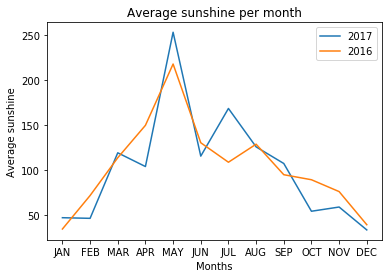

In [34]:
plt.plot(monthly_sunshine_2016_2017.drop('Year', axis=1).columns.tolist(), monthly_sunshine_2016_2017[monthly_sunshine_2016_2017['Year'] == 2017].drop('Year', axis=1).values.flatten().tolist())
plt.plot(monthly_sunshine_2016_2017.drop('Year', axis=1).columns.tolist(), monthly_sunshine_2016_2017[monthly_sunshine_2016_2017['Year'] == 2016].drop('Year', axis=1).values.flatten().tolist())
plt.xlabel('Months')
plt.ylabel('Average sunshine')
plt.title("Average sunshine per month")
plt.legend(['2017', '2016'])

Text(0.5,1,'Average sunshine per month vs Number of crimes per month in 2017')

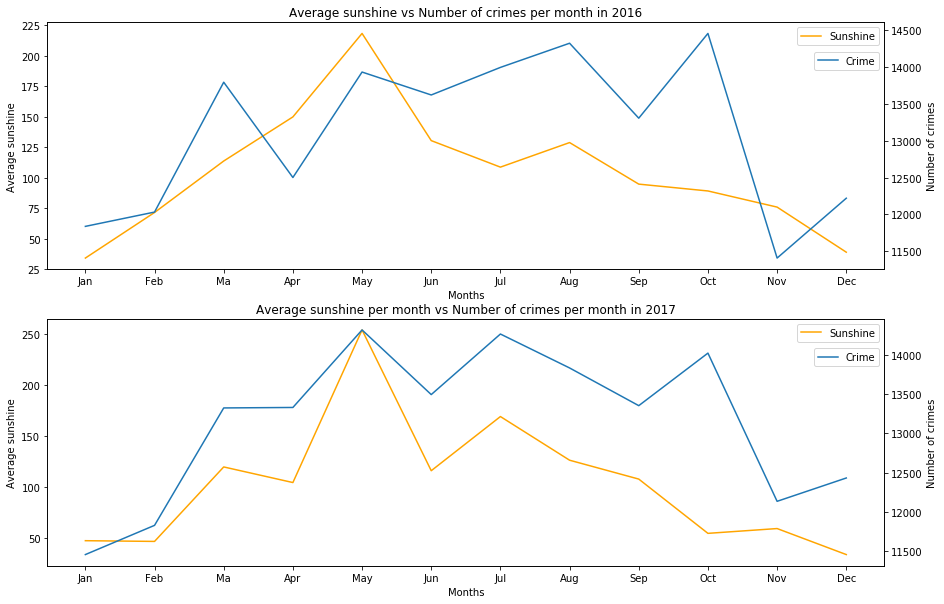

In [35]:
plt.figure(figsize=(15,10))
plt.subplot(2, 1, 1)
ax = sb.lineplot(np.arange(0, 12, step=1.0), monthly_sunshine_2016_2017[monthly_sunshine_2016_2017['Year'] == 2016].drop('Year', axis=1).values.flatten().tolist(), color='orange')
ax2 = ax.twinx()

yvals2016 = psni_crime_data_grouped_month_year[psni_crime_data_grouped_month_year.Year == 2016].counts

ax2.set(xticks=(np.arange(0, 12, step=1.0)))
ax2.set_xticklabels(('Jan', 'Feb', 'Ma', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'))

sb.lineplot((np.arange(0, 12, step=1.0)), yvals2016, ax=ax2)
ax.set_xlabel('Months')
ax.set_ylabel('Average sunshine')
ax2.set_ylabel('Number of crimes')

plt.title("Average sunshine vs Number of crimes per month in 2016")
ax.legend(['Sunshine'])
ax2.legend(['Crime'], bbox_to_anchor=(1,0.9), loc="upper right")

plt.subplot(2,1,2)
ax = sb.lineplot(np.arange(0, 12, step=1.0), monthly_sunshine_2016_2017[monthly_sunshine_2016_2017['Year'] == 2017].drop('Year', axis=1).values.flatten().tolist(), color='orange')
ax2 = ax.twinx()

yvals2016 = psni_crime_data_grouped_month_year[psni_crime_data_grouped_month_year.Year == 2017].counts

ax2.set(xticks=(np.arange(0, 12, step=1.0)))
ax2.set_xticklabels(('Jan', 'Feb', 'Ma', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'))

sb.lineplot((np.arange(0, 12, step=1.0)), yvals2016, ax=ax2)

ax.set_xlabel('Months')
ax.set_ylabel('Average sunshine')
ax2.set_ylabel('Number of crimes')

ax.legend(['Sunshine'])
ax2.legend(['Crime'], bbox_to_anchor=(1,0.9), loc="upper right")

plt.title("Average sunshine per month vs Number of crimes per month in 2017")

<b> There appears to be some correlation between sunshine and crime, with values especially in 2017 having a relationship.  </b>

In [36]:
#corr_sunshine_month_2016_2017 = monthly_sunshine_2016_2017.merge(psni_crime_data_grouped_month_year)

corr_sunshine_month_2016_2017 = pd.DataFrame(columns=['counts', 'sunshine'])
months = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
crimes_month_year_2016_2017 = psni_crime_data_grouped_month_year[(psni_crime_data_grouped_month_year['Year'] == 2016) | (psni_crime_data_grouped_month_year['Year'] == 2017)].reset_index()
for index,row in crimes_month_year_2016_2017.iterrows():
    counts = row['counts']
    month = months[row['Month']-1]
    sunshine = monthly_sunshine_2016_2017[monthly_sunshine_2016_2017['Year'] == row['Year']].iloc[0][month]
    corr_sunshine_month_2016_2017 = corr_sunshine_month_2016_2017.append({'counts': counts, 'sunshine': sunshine}, ignore_index=True)

corr_sunshine_month_2016_2017.head()

,counts,sunshine
0,11837.0,34.3
1,11458.0,46.9
2,12031.0,71.6
3,11830.0,46.2
4,13793.0,113.7


In [37]:
corr_sunshine_month_2016_2017.corr()

,counts,sunshine
counts,1.000000,0.648179
sunshine,0.648179,1.000000


<b> There is a moderate positive linear relationship between average monthly sunshine and the number of crimes per month. Let's take a look at the correlation of average monthly sunshine and crimes identified as being potentially seasonal dependent: : anti social behaviour, bicycle theft, criminal damage, arson, drug crime, theft and vehicle crime </b>

In [38]:
psni_crime_data_grouped_crime_type.head()

,Month,Crime type,counts
0,1,Anti-social behaviour,8366
1,1,Bicycle theft,87
2,1,Burglary,1228
3,1,Criminal damage and arson,2781
4,1,Drugs,890


In [39]:
psni_crime_data_grouped_crime_type_month_year = psni_crime_data_ranged.groupby(['Year','Month','Crime type']).size().reset_index(name='counts')
psni_crime_data_grouped_crime_type_month_year['sunshine'] = None

months = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
for index,row in psni_crime_data_grouped_crime_type_month_year.iterrows():
    month = months[row['Month']-1]
    sunshine = monthly_sunshine_2016_2017[monthly_sunshine_2016_2017['Year'] == row['Year']].iloc[0][month]
    psni_crime_data_grouped_crime_type_month_year.at[index, 'sunshine'] = sunshine

psni_crime_data_grouped_crime_type_month_year[['sunshine']] = psni_crime_data_grouped_crime_type_month_year[['sunshine']].apply(pd.to_numeric)
psni_crime_data_grouped_crime_type_month_year = psni_crime_data_grouped_crime_type_month_year.drop(['Year'], axis=1)
psni_crime_data_grouped_crime_type_month_year.head()

,Month,Crime type,counts,sunshine
0,1,Anti-social behaviour,4083,34.3
1,1,Bicycle theft,46,34.3
2,1,Burglary,670,34.3
3,1,Criminal damage and arson,1379,34.3
4,1,Drugs,430,34.3


In [40]:
unique_crimes = psni_crime_data['Crime type'].unique()
correlation_crime_type = pd.DataFrame(columns=['Crime type', 'Correlation'])
for crime in unique_crimes:
    crime_type_counts = psni_crime_data_grouped_crime_type_month_year[psni_crime_data_grouped_crime_type_month_year['Crime type'] == crime]
    crime_type_counts = crime_type_counts.drop(['Crime type', 'Month'], axis=1)
    correlation = crime_type_counts.corr()
    correlation_crime_type = correlation_crime_type.append({'Crime type': crime, 'Correlation': correlation.iloc[0]['sunshine']}, ignore_index=True)
    
correlation_crime_type.nlargest(5, ['Correlation']).head()

,Crime type,Correlation
0,Anti-social behaviour,0.603072
12,Violence and sexual offences,0.593985
6,Possession of weapons,0.522555
3,Criminal damage and arson,0.513288
5,Other theft,0.465889


In [41]:
correlation_crime_type.nsmallest(5, ['Correlation']).head()

,Crime type,Correlation
11,Vehicle crime,-0.334865
4,Drugs,-0.259633
10,Theft from the person,-0.258743
2,Burglary,-0.177319
8,Robbery,-0.038499


<b>The number of anti social behaviour, Criminal damage and arson, drug and theft crimes I identified as being seasonal dependent earlier do have a moderate positive correlation to the average sunshine per month. Vehicle crime also identified has a moderate negative correlation to the average sunshine per month. Anti-social behaviour has the strongest correlation to sunshine and I will visualise this to verify this:</b>

Text(0,0.5,'Average sunshine per month')

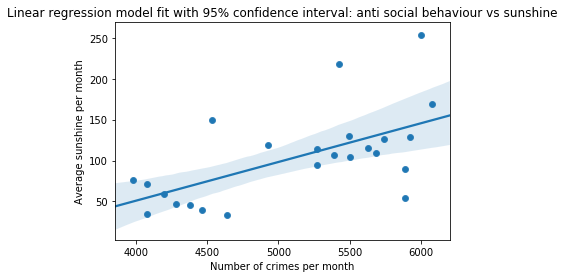

In [42]:
anti_social_crime = psni_crime_data_grouped_crime_type_month_year[psni_crime_data_grouped_crime_type_month_year['Crime type'] == 'Anti-social behaviour'].reset_index(drop=True)
ax = sb.scatterplot(anti_social_crime.counts, anti_social_crime.sunshine)


numpyArrayX = anti_social_crime.counts.values
numpyArrayY = anti_social_crime.sunshine.values
sb.regplot(anti_social_crime.counts,anti_social_crime.sunshine);
plt.title("Linear regression model fit with 95% confidence interval: anti social behaviour vs sunshine")
plt.xlabel('Number of crimes per month')
plt.ylabel('Average sunshine per month')

In [43]:
anti_social_crime = psni_crime_data[(psni_crime_data['Crime type'] == 'Anti-social behaviour') & (psni_crime_data['Has_Location'] == True)].reset_index(drop=True)
anti_social_crime_sampled = anti_social_crime
anti_social_crime_sampled.head()
# anti_social_crime_sampled = anti_social_crime_sampled.drop(['index'], axis=1)
# anti_social_crime_sampled = anti_social_crime_sampled.drop(['index'], axis=1)

,index,Longitude,Latitude,Location,Crime type,Has_Location,Year,Month,Week,Quarter
0,0,-7.378949,54.717334,dublin street,Anti-social behaviour,True,2015,8,31,3
1,1,-5.891082,54.222501,bracken avenue,Anti-social behaviour,True,2015,8,31,3
2,2,-5.667276,54.663573,high street,Anti-social behaviour,True,2015,8,31,3
3,3,-5.962330,54.587243,rodney parade,Anti-social behaviour,True,2015,8,31,3
4,4,-5.894063,54.590423,brenda street,Anti-social behaviour,True,2015,8,31,3


In [44]:
# anti_social_crime_sampled.to_csv('anti_social_crime.csv', index=False)

In [45]:
# anti_social_crime = pd.read_csv('anti_social_crime.csv')
# for index, row in anti_social_crime.iterrows():
#         longitude = row['Longitude']
#         latitude = row['Latitude']
#         url = f'https://data.police.uk/api/locate-neighbourhood?q={latitude},{longitude}'
#         response = requests.get(url)
#         neighbourhood = response.json()['neighbourhood']
#         anti_social_crime.at[index, 'Neighbourhood'] = neighbourhood
#         if (index % 1000 == 0):
#             print('Here')
#             anti_social_crime.to_csv('anti_social_crime.csv', index=False)

# anti_social_crime = pd.read_csv('anti_social_crime.csv')

anti_social_crime_sampled = pd.read_csv('anti_social_crime.csv')
anti_social_crime_sampled.head()

,index,Longitude,Latitude,Location,Crime type,Has_Location,Year,Month,Week,Quarter,Neighbourhood
0,0,-7.378949,54.717334,dublin street,Anti-social behaviour,True,2015,8,31,3,Strabane
1,1,-5.891082,54.222501,bracken avenue,Anti-social behaviour,True,2015,8,31,3,Downpatrick
2,2,-5.667276,54.663573,high street,Anti-social behaviour,True,2015,8,31,3,Newtownards
3,3,-5.962330,54.587243,rodney parade,Anti-social behaviour,True,2015,8,31,3,Woodbourne
4,4,-5.894063,54.590423,brenda street,Anti-social behaviour,True,2015,8,31,3,Strandtown


In [46]:
anti_social_crime_sampled.dtypes

index              int64
Longitude        float64
Latitude         float64
Location          object
Crime type        object
Has_Location        bool
Year               int64
Month              int64
Week               int64
Quarter            int64
Neighbourhood     object
dtype: object

In [47]:
anti_social_crime_sampled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170910 entries, 0 to 170909
Data columns (total 11 columns):
index            170910 non-null int64
Longitude        170910 non-null float64
Latitude         170910 non-null float64
Location         147430 non-null object
Crime type       170910 non-null object
Has_Location     170910 non-null bool
Year             170910 non-null int64
Month            170910 non-null int64
Week             170910 non-null int64
Quarter          170910 non-null int64
Neighbourhood    170898 non-null object
dtypes: bool(1), float64(2), int64(5), object(3)
memory usage: 13.2+ MB


In [48]:
anti_social_crime_sampled = anti_social_crime_sampled[~anti_social_crime_sampled['Neighbourhood'].isnull()]

In [49]:
neighbourhood_district = {
    'Newtownabbey': 'Antrim and Newtownabbey',
    'Antrim': 'Antrim and Newtownabbey',
    'Newtownards': 'Ards and North Down',
    'Armagh': 'Armagh City, Banbridge and Craigavon',
    'Lurgan': 'Armagh City, Banbridge and Craigavon',
    'Lisburn Road': 'Belfast City',
    'Strandtown': 'Belfast City',
    'Tennent Street': 'Belfast City',
    'Woodbourne': 'Belfast City',
    'Coleraine': 'Causeway Coast and Glens',
    'Limavady': 'Causeway Coast and Glens',
    'Strabane': 'Derry City & Strabane',
    'Strand Road': 'Derry City & Strabane',
    'Enniskillen':'Fermanagh and Omagh',
    'Lisnaskea': 'Fermanagh and Omagh',
    'Omagh': 'Fermanagh and Omagh',
    'Lisburn':'Lisburn and Castlereagh',
    'Castlereagh': 'Lisburn and Castlereagh',
    'Ballymena': 'Mid and East Antrim',
    'Larne': 'Mid and East Antrim',
    'Dungannon': 'Mid Ulster',
    'Magherafelt': 'Mid Ulster',
    'Crossmaglen': 'Newry, Mourne and Down',
    'Downpatrick': 'Newry, Mourne and Down',
    'Newry': 'Newry, Mourne and Down',
    'Newtownhamilton': 'Newry, Mourne and Down'
}

def map_neighbourhood_district(row):
    neighbourhood = row['Neighbourhood']
    district = neighbourhood_district[neighbourhood]
    return district

In [50]:
anti_social_crime_sampled['Policing_District'] = anti_social_crime_sampled.apply(lambda row: map_neighbourhood_district (row),axis=1)

In [51]:
anti_social_crime_sampled.head()

,index,Longitude,Latitude,Location,Crime type,Has_Location,Year,Month,Week,Quarter,Neighbourhood,Policing_District
0,0,-7.378949,54.717334,dublin street,Anti-social behaviour,True,2015,8,31,3,Strabane,Derry City & Strabane
1,1,-5.891082,54.222501,bracken avenue,Anti-social behaviour,True,2015,8,31,3,Downpatrick,"Newry, Mourne and Down"
2,2,-5.667276,54.663573,high street,Anti-social behaviour,True,2015,8,31,3,Newtownards,Ards and North Down
3,3,-5.962330,54.587243,rodney parade,Anti-social behaviour,True,2015,8,31,3,Woodbourne,Belfast City
4,4,-5.894063,54.590423,brenda street,Anti-social behaviour,True,2015,8,31,3,Strandtown,Belfast City


In [52]:
# # neighbourhood_population = pd.DataFrame(columns=['Neighbourhood', 'Population'])

# # for key in neighbourhood_district:
# #     url = f'https://data.police.uk/api/northern-ireland/{key}'
# #     response = requests.get(url)
# #     population = response.json()['population']
# #     neighbourhood_population = neighbourhood_population.append({'Neighbourhood': key, 'Population': population}, ignore_index=True)
neighbourhood_population = pd.read_csv('neighbourhood_population.csv')
# # neighbourhood_population.to_csv('neighbourhood_population.csv',index=False)

In [53]:
grouped_asb_neighbourhood = anti_social_crime_sampled.groupby('Neighbourhood').size().reset_index(name='count')
# grouped_asb_neighbourhood

In [54]:
grouped_asb_neighbourhood = grouped_asb_neighbourhood.merge(neighbourhood_population, on='Neighbourhood')

def crime_per_population(row):
    population = row['Population']
    asb_count = row['count']
    return asb_count/population
grouped_asb_neighbourhood['ASB_per_population'] = grouped_asb_neighbourhood.apply(lambda row: crime_per_population(row), axis=1)

In [55]:
grouped_asb_neighbourhood.sort_values(by=['ASB_per_population'], ascending=False).head(30)

,Neighbourhood,count,Population,ASB_per_population
12,Lisburn Road,18191,33859,0.537257
24,Tennent Street,13905,55389,0.251043
25,Woodbourne,10378,53759,0.193047
22,Strand Road,11465,74386,0.154128
16,Newry,6128,46596,0.131513
23,Strandtown,9573,73175,0.130823
0,Antrim,4785,36860,0.129816
14,Lurgan,12308,95413,0.128997
4,Coleraine,8022,62423,0.128510
7,Dungannon,5817,46499,0.125099


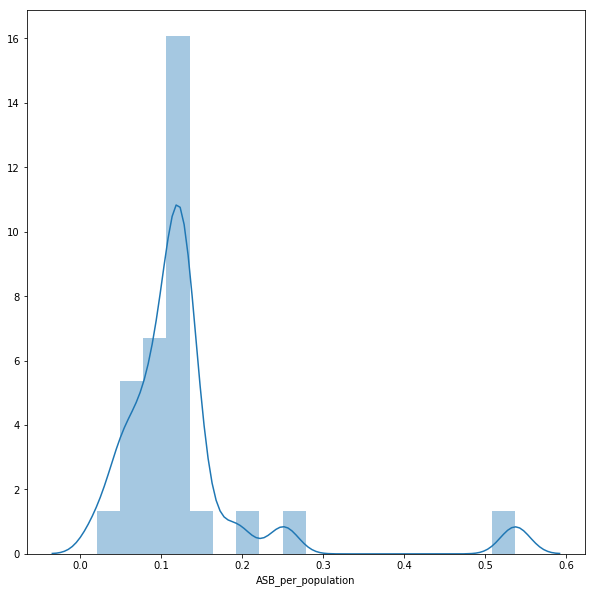

In [56]:
plt.figure(figsize=(10,10))
sb.distplot(grouped_asb_neighbourhood['ASB_per_population'])

<b> Lisburn road neighbourhood is a big outlier </b>

In [57]:
grouped_asb_neighbourhood.corr()

,count,Population,ASB_per_population
count,1.000000,0.679060,0.794265
Population,0.679060,1.000000,0.139652
ASB_per_population,0.794265,0.139652,1.000000


<b> There is a positive correlation between the number of ASB crimes being committed and number of people living in a neighbourhood </b>

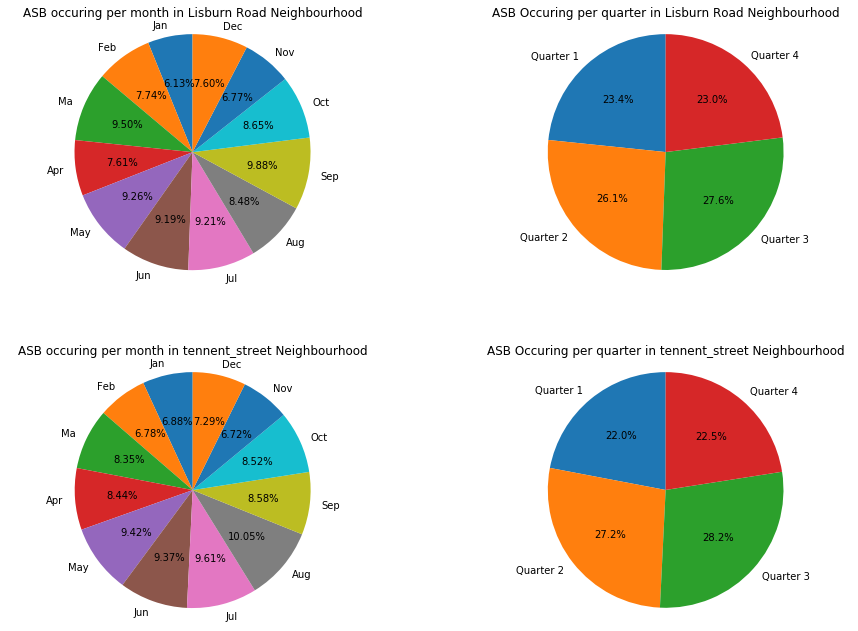

In [58]:
lisburn_road = anti_social_crime_sampled[anti_social_crime_sampled.Neighbourhood == 'Lisburn Road']
lisburn_road = lisburn_road[(lisburn_road['Year'] == 2016) | (lisburn_road['Year'] == 2017)].reset_index()
lisburn_road_month = lisburn_road.groupby(['Month']).size().reset_index(name='counts')
lisburn_road_quarter = lisburn_road.groupby(['Quarter']).size().reset_index(name='counts')


plt.figure(figsize=(15,11))

plt.subplot(2, 2, 1)
plt.pie(lisburn_road_month['counts'], labels = ('Jan', 'Feb', 'Ma', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'), \
        autopct='%1.2f%%', shadow=False, startangle=90)
plt.axis('equal')
plt.title("ASB occuring per month in Lisburn Road Neighbourhood")

plt.subplot(2,2, 2)
plt.title("Chart of all crimes and anti-social behaviour occuring per quarter")
plt.pie(lisburn_road_quarter['counts'], labels = ('Quarter 1', 'Quarter 2', 'Quarter 3', 'Quarter 4'), autopct='%1.1f%%', shadow=False, startangle=90)
plt.axis('equal')
plt.title("ASB Occuring per quarter in Lisburn Road Neighbourhood")

tennent_street = anti_social_crime_sampled[anti_social_crime_sampled.Neighbourhood == 'Tennent Street']
tennent_street = tennent_street[(tennent_street['Year'] == 2016) | (tennent_street['Year'] == 2017)].reset_index()
tennent_street_month = tennent_street.groupby(['Month']).size().reset_index(name='counts')
tennent_street_quarter = tennent_street.groupby(['Quarter']).size().reset_index(name='counts')

plt.subplot(2, 2, 3)
plt.pie(tennent_street_month['counts'], labels = ('Jan', 'Feb', 'Ma', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'), \
        autopct='%1.2f%%', shadow=False, startangle=90)
plt.axis('equal')
plt.title("ASB occuring per month in tennent_street Neighbourhood")

plt.subplot(2,2, 4)
plt.title("Chart of all crimes and anti-social behaviour occuring per quarter")
plt.pie(tennent_street_quarter['counts'], labels = ('Quarter 1', 'Quarter 2', 'Quarter 3', 'Quarter 4'), autopct='%1.1f%%', shadow=False, startangle=90)
plt.axis('equal')
plt.title("ASB Occuring per quarter in tennent_street Neighbourhood")

plt.subplots_adjust(hspace=0.3)
plt.subplots_adjust(wspace=0.3)

<b> 
Lisburn Road: The highest number of ASB crimes occured in 2016-17 in September. The summer months (Quarter 3) have high rates of ASB but in March there is a notable rise. I am going to link the sunshine data to the ASB dataset for Lisburn Road and see if there's any trend. 

Tennent Street: The highest number of ASB crimes occured - in 2016-17 in August. The summer months months (Quarter 3) have high rates of ASB. There is no notable rise like in Lisburn Road for March</b>

<b> I'm going link the sunlight data to see if March has a seasonal effect on the number of asb crimes. </b>

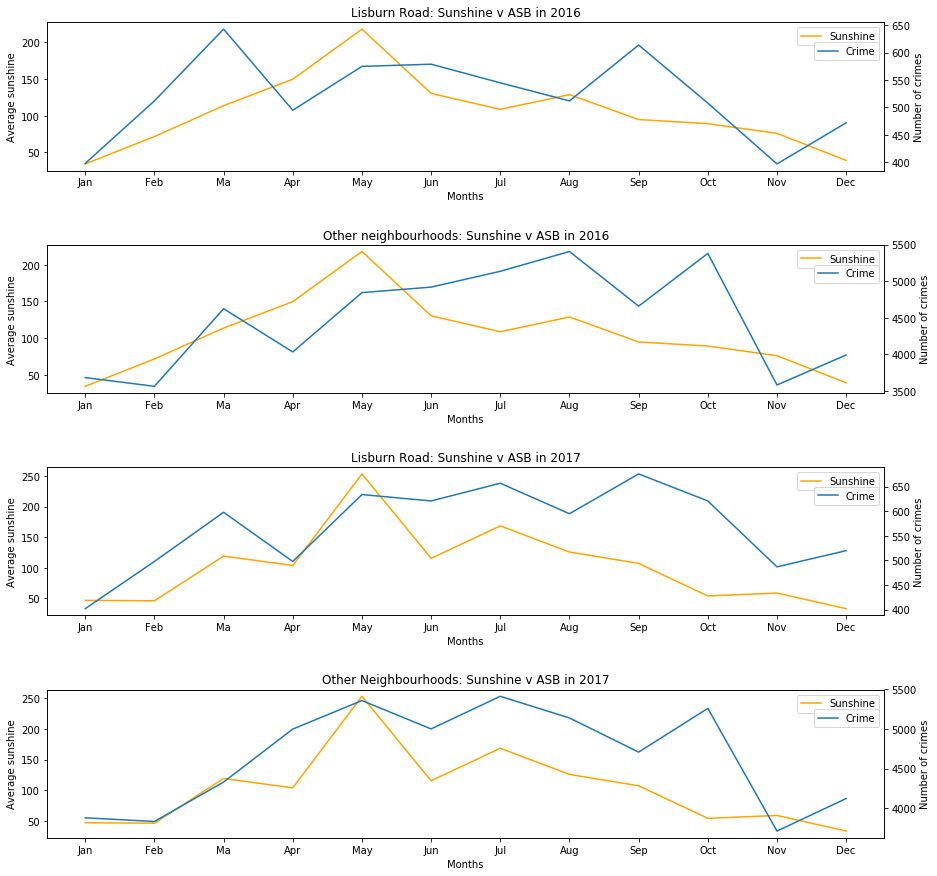

In [95]:
lisburn_road_sampled = anti_social_crime_sampled[anti_social_crime_sampled.Neighbourhood == 'Lisburn Road']
lisburn_road = lisburn_road_sampled[(lisburn_road_sampled['Year'] == 2016) | (lisburn_road_sampled['Year'] == 2017)].reset_index()
lisburn_road = lisburn_road.groupby(['Month', 'Year']).size().reset_index(name='counts')

all_others = anti_social_crime_sampled[anti_social_crime_sampled.Neighbourhood != 'Lisburn Road']
all_others = all_others[(all_others['Year'] == 2016) | (all_others['Year'] == 2017)].reset_index()
all_others = all_others.groupby(['Month', 'Year']).size().reset_index(name='counts')


plt.figure(figsize=(15,15))
plt.subplot(4, 1, 1)
ax = sb.lineplot(np.arange(0, 12, step=1.0), monthly_sunshine_2016_2017[monthly_sunshine_2016_2017['Year'] == 2016].drop('Year', axis=1).values.flatten().tolist(), color='orange')
ax2 = ax.twinx()

yvals2016 = lisburn_road[lisburn_road.Year == 2016].counts

ax2.set(xticks=(np.arange(0, 12, step=1.0)))
ax2.set_xticklabels(('Jan', 'Feb', 'Ma', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'))

sb.lineplot((np.arange(0, 12, step=1.0)), yvals2016, ax=ax2)
ax.set_xlabel('Months')
ax.set_ylabel('Average sunshine')
ax2.set_ylabel('Number of crimes')

plt.title("Lisburn Road: Sunshine v ASB in 2016")
ax.legend(['Sunshine'])
ax2.legend(['Crime'], bbox_to_anchor=(1,0.9), loc="upper right")

plt.subplot(4,1,2)
ax = sb.lineplot(np.arange(0, 12, step=1.0), monthly_sunshine_2016_2017[monthly_sunshine_2016_2017['Year'] == 2016].drop('Year', axis=1).values.flatten().tolist(), color='orange')
ax2 = ax.twinx()

yvals2016 = all_others[all_others.Year == 2016].counts

ax2.set(xticks=(np.arange(0, 12, step=1.0)))
ax2.set_xticklabels(('Jan', 'Feb', 'Ma', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'))

sb.lineplot((np.arange(0, 12, step=1.0)), yvals2016, ax=ax2)

ax.set_xlabel('Months')
ax.set_ylabel('Average sunshine')
ax2.set_ylabel('Number of crimes')

ax.legend(['Sunshine'])
ax2.legend(['Crime'], bbox_to_anchor=(1,0.9), loc="upper right")

plt.title("Other neighbourhoods: Sunshine v ASB in 2016")


plt.subplot(4,1,3)
ax = sb.lineplot(np.arange(0, 12, step=1.0), monthly_sunshine_2016_2017[monthly_sunshine_2016_2017['Year'] == 2017].drop('Year', axis=1).values.flatten().tolist(), color='orange')
ax2 = ax.twinx()

yvals2016 = lisburn_road[lisburn_road.Year == 2017].counts

ax2.set(xticks=(np.arange(0, 12, step=1.0)))
ax2.set_xticklabels(('Jan', 'Feb', 'Ma', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'))

sb.lineplot((np.arange(0, 12, step=1.0)), yvals2016, ax=ax2)

ax.set_xlabel('Months')
ax.set_ylabel('Average sunshine')
ax2.set_ylabel('Number of crimes')

ax.legend(['Sunshine'])
ax2.legend(['Crime'], bbox_to_anchor=(1,0.9), loc="upper right")

plt.title("Lisburn Road: Sunshine v ASB in 2017")

plt.subplot(4,1,4)
ax = sb.lineplot(np.arange(0, 12, step=1.0), monthly_sunshine_2016_2017[monthly_sunshine_2016_2017['Year'] == 2017].drop('Year', axis=1).values.flatten().tolist(), color='orange')
ax2 = ax.twinx()

yvals2016 = all_others[all_others.Year == 2017].counts

ax2.set(xticks=(np.arange(0, 12, step=1.0)))
ax2.set_xticklabels(('Jan', 'Feb', 'Ma', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'))

sb.lineplot((np.arange(0, 12, step=1.0)), yvals2016, ax=ax2)

ax.set_xlabel('Months')
ax.set_ylabel('Average sunshine')
ax2.set_ylabel('Number of crimes')

ax.legend(['Sunshine'])
ax2.legend(['Crime'], bbox_to_anchor=(1,0.9), loc="upper right")

plt.title("Other Neighbourhoods: Sunshine v ASB in 2017")
plt.subplots_adjust(hspace=0.5)
plt.subplots_adjust(wspace=0.5)

<b> On the Lisburn Road, there's a rise early in January, February and March. In March 2016 there is a notable rise. On the Lisburn Road there is a sharp rise in September, but a fall in October while in other neighbourhoods there is a sharp rise. May, June, July, August months see a rise in other neighbourhoods. </b>

<b> I'm going to take a look at March 2016 and where ASB on the Lisburn Road is happening. </b>

In [173]:
m = folium.Map(location=[54.5668, -5.95328], zoom_start=12)

lisburn_road_march_2016 = lisburn_road_sampled[(lisburn_road_sampled['Year'] == 2016) & (lisburn_road_sampled['Month'] == 3)].reset_index()

lisburn_road_november_2016 = lisburn_road_sampled[(lisburn_road_sampled['Year'] == 2016) & (lisburn_road_sampled['Month'] == 11)].reset_index()

lisburn_road_september_2016 = lisburn_road_sampled[(lisburn_road_sampled['Year'] == 2016) & (lisburn_road_sampled['Month'] == 9)].reset_index()

lisburn_road_september_2017 = lisburn_road_sampled[(lisburn_road_sampled['Year'] == 2017) & (lisburn_road_sampled['Month'] == 9)].reset_index()

asb_lisburn_road_coords_march_2016 = []
                            
for index, row in lisburn_road_march_2016.iterrows():
    coords = (row['Latitude'], row['Longitude'])
    asb_lisburn_road_coords_march_2016.append(list(coords))

asb_lisburn_road_coords_november_2016 = []

for index, row in lisburn_road_november_2016.iterrows():
    coords = (row['Latitude'], row['Longitude'])
    asb_lisburn_road_coords_november_2016.append(list(coords))
    
asb_lisburn_road_coords_september_2016 = []

for index, row in lisburn_road_september_2016.iterrows():
    coords = (row['Latitude'], row['Longitude'])
    asb_lisburn_road_coords_september_2016.append(list(coords))
    
asb_lisburn_road_coords_september_2017 = []

for index, row in lisburn_road_september_2017.iterrows():
    coords = (row['Latitude'], row['Longitude'])
    asb_lisburn_road_coords_september_2017.append(list(coords))

asb_lisburn_road_coords = []

asb_lisburn_road_coords.append(asb_lisburn_road_coords_march_2016)
asb_lisburn_road_coords.append(asb_lisburn_road_coords_september_2016)
asb_lisburn_road_coords.append(asb_lisburn_road_coords_november_2016)
asb_lisburn_road_coords.append(asb_lisburn_road_coords_september_2017)


HeatMapWithTime(asb_lisburn_road_coords, index=['March 2016', 'September 2016', 'November 2016', 'September 2017']).add_to(m)
#m.add_child(HeatMap(asb_lisburn_road_coords_november_2016, gradient={0: 'blue', 0: 'lime', .4: 'red'}))

m

<b> Holylands March 2016 </b>
<img src="holylands march 2016.PNG">
<b> Holylands September 2016 </b>
<img src="holylands september 2016.PNG">
<b> Holylands November 2016 </b>
<img src="holylands november 2016.PNG">
<b> Holylands September 2017 </b>
<img src="holylands september 2017.PNG">
<b> Holylands Hotspot in Google Maps </b>
<img src="holylands hotspot.PNG">

In [75]:
#corr_sunshine_month_2016_2017 = monthly_sunshine_2016_2017.merge(psni_crime_data_grouped_month_year)

corr_sunshine_month_2016_2017 = pd.DataFrame(columns=['counts', 'sunshine'])
months = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
crimes_month_year_2016_2017 = lisburn_road[(lisburn_road['Year'] == 2016) | (lisburn_road['Year'] == 2017)].reset_index()
for index,row in lisburn_road.iterrows():
    counts = row['counts']
    month = months[row['Month']-1]
    sunshine = monthly_sunshine_2016_2017[monthly_sunshine_2016_2017['Year'] == row['Year']].iloc[0][month]
    corr_sunshine_month_2016_2017 = corr_sunshine_month_2016_2017.append({'counts': counts, 'sunshine': sunshine}, ignore_index=True)

corr_sunshine_month_2016_2017.head()

,counts,sunshine
0,398.0,34.3
1,402.0,46.9
2,512.0,71.6
3,498.0,46.2
4,643.0,113.7


In [76]:
corr_sunshine_month_2016_2017.corr()

,counts,sunshine
counts,1.000000,0.547695
sunshine,0.547695,1.000000


In [81]:
#corr_sunshine_month_2016_2017 = monthly_sunshine_2016_2017.merge(psni_crime_data_grouped_month_year)

corr_sunshine_month_2016_2017 = pd.DataFrame(columns=['counts', 'sunshine'])
months = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
crimes_month_year_2016_2017 = all_others[(all_others['Year'] == 2016) | (all_others['Year'] == 2017)].reset_index()
for index,row in all_others.iterrows():
    counts = row['counts']
    month = months[row['Month']-1]
    sunshine = monthly_sunshine_2016_2017[monthly_sunshine_2016_2017['Year'] == row['Year']].iloc[0][month]
    corr_sunshine_month_2016_2017 = corr_sunshine_month_2016_2017.append({'counts': counts, 'sunshine': sunshine}, ignore_index=True)

corr_sunshine_month_2016_2017.head()

,counts,sunshine
0,3684.0,34.3
1,3879.0,46.9
2,3565.0,71.6
3,3833.0,46.2
4,4624.0,113.7


In [82]:
corr_sunshine_month_2016_2017.corr()

,counts,sunshine
counts,1.000000,0.587466
sunshine,0.587466,1.000000


In [78]:
local_crime_levels = pd.read_csv('data/Perceptions of Crime Findings/local_crime_levels.csv')
local_crime_levels.head()

,Year,More crime,A lot more crime,A little more crime,Same,Less crime,Unweighted base
0,1998,41.000000,14.000000,27.000000,47.00000,12.000000,2648
1,2001,55.000000,26.000000,29.000000,36.00000,8.000000,2597
2,2003/04,52.000000,22.000000,30.000000,36.00000,12.000000,2644
3,2005,44.444444,17.059315,27.385129,42.35589,13.199666,3076
4,2006/07,44.007763,17.256995,26.750768,41.59793,14.394307,3171


In [64]:
overall_crime_levels = pd.read_csv('data/Perceptions of Crime Findings/overall_crime_levels.csv')
overall_crime_levels.head()

,Year,More crime,A lot more crime,A little more crime,Same,Less crime,Unweighted base
0,2003/04,79.000000,49.000000,30.000000,14.000000,7.000000,2704
1,2005,73.997676,41.705404,32.292272,16.879721,9.122603,3578
2,2006/07,72.661972,40.140845,32.521127,17.507042,9.830986,3678
3,2007/08,65.437346,33.890869,31.546477,20.235810,14.326844,3790
4,2008/09,63.912001,32.449584,31.462417,23.071499,13.016500,3737


In [65]:
asb_big_problem = pd.read_csv('data/Perceptions of Crime Findings/different_types_asb_big_problems.csv')
asb_big_problem.head()

,Year,Perceived high level of ASB,Abandoned or burnt-out cars,Noisy neighbours or loud parties,People being drunk or rowdy in public places,People using or dealing drugs,Teenagers hanging around on streets,Rubbish or litter lying around,"Vandalism, graffiti and other deliberate damage to property",Unweighted base
0,1998,NaN,NaN,6.000000,NaN,21.000000,20.000000,22.000000,23.000000,3058
1,2001,NaN,8.000000,7.000000,NaN,29.000000,33.000000,27.000000,32.000000,3007
2,2003/04,18.067075,10.469554,7.753479,23.528431,30.714029,30.696517,29.174950,28.173682,3104
3,2005,16.914095,8.404385,9.566685,24.978820,28.137995,29.062236,27.932489,25.754158,3691
4,2006/07,14.982217,6.795451,8.293417,23.425900,25.809313,27.403451,27.099863,23.442421,3788


In [66]:
asb_biggest_problem = pd.read_csv('data/Perceptions of Crime Findings/different_types_asb_biggest_problem.csv')
asb_biggest_problem.head()

,Year,Abandoned or burnt-out cars,Noisy neighbours or loud parties,People being drunk or rowdy in public places,People using or dealing drugs,Teenagers hanging around on streets,Rubbish or litter lying around,"Vandalism, graffiti and other deliberate damage to property",None of these,Unweighted base
0,2008/09,0.749625,3.720867,10.849121,7.755213,22.993049,15.810277,6.623961,31.497887,3852
1,2009/10,0.934216,4.346698,11.327365,7.045543,20.903075,15.842740,7.292072,32.308291,4090
2,2010/11,0.951760,3.728814,9.895698,9.191656,18.591917,17.913950,6.636245,33.089961,4066
3,2011/12,0.774994,4.417463,10.036166,8.951175,17.514854,18.496513,6.962025,32.846810,4055
4,2012/13,0.447840,4.425711,8.245522,10.089568,15.964173,18.005796,5.518967,37.302424,4049


In [67]:
asb_perception_districts_2016_2017 = pd.read_csv('data/Perceptions of Crime Findings/perceptions_asb_district_2016_2017.csv')
asb_perception_districts_2016_2017.head(20)

,Policing District,LE Abandoned or burnt-out cars,BE Abandoned or burnt-out cars,HE Abandoned or burnt-out cars,LE Noisy neighbours or loud parties,BE Noisy neighbours or loud parties,HE Noisy neighbours or loud parties,LE People being drunk or rowdy in public places,BE People being drunk or rowdy in public places,HE People being drunk or rowdy in public places,...,LE Rubbish or litter lying around,BE Rubbish or litter lying around,HE Rubbish or litter lying around,"LE Vandalism, graffiti and other deliberate damage to property","BE Vandalism, graffiti and other deliberate damage to property","HE Vandalism, graffiti and other deliberate damage to property",LE Perceived high level of ASB,BE Perceived high level of ASB,HE Perceived high level of ASB,Unweighted base
0,Antrim and Newtownabbey,0.481572,4.065041,7.648509,3.170822,8.130081,13.089340,5.352613,11.065574,16.778534,...,10.931940,17.886179,24.840418,7.230280,13.414634,19.598988,2.860839,7.929515,12.998192,140
1,Ards and North Down,0.000000,0.000000,0.000000,1.799300,5.483871,9.168442,9.902443,15.806452,21.710460,...,17.262591,24.193548,31.124506,4.393174,9.032258,13.671342,2.847035,7.191781,11.536526,176
2,"Armagh City, Banbridge and Craigavon",0.108781,2.356021,4.603260,2.120337,5.497382,8.874428,8.311456,13.350785,18.390115,...,21.357251,28.010471,34.663692,6.788355,11.518325,16.248294,4.833991,9.214092,13.594194,210
3,Belfast City,3.156697,5.756579,8.356461,7.256858,10.708402,14.159946,17.412641,22.039474,26.666307,...,27.808265,33.059211,38.310156,14.243584,18.585526,22.927469,11.304240,15.492958,19.681675,370
4,Causeway Coast and Glens,0.000000,1.048951,2.817385,2.566198,6.993007,11.419816,10.296215,16.783217,23.270219,...,19.542115,27.272727,35.003340,4.900232,10.139860,15.379489,4.098770,9.293680,14.488591,153
5,Derry City & Strabane,9.225775,15.210356,21.194937,6.045529,11.326861,16.608193,13.390843,20.064725,26.738606,...,16.836348,23.948220,31.060093,13.390843,20.064725,26.738606,10.462813,16.955017,23.447221,166
6,Fermanagh and Omagh,0.478317,4.602510,8.726704,0.722797,5.020921,9.319044,4.750195,10.878661,17.007127,...,3.818914,9.623431,15.427948,0.975567,5.439331,9.903094,0.731079,5.128205,9.525332,119
7,Lisburn and Castlereagh,0.000000,1.709402,4.169315,1.726277,6.329114,10.931951,2.296840,7.203390,12.109940,...,22.463446,31.223629,39.983811,7.041769,13.502110,19.962450,2.370742,7.456140,12.541539,129
8,Mid and East Antrim,0.000000,1.532567,3.686128,0.466322,3.831418,7.196513,7.436188,13.409962,19.383736,...,21.154371,29.118774,37.083177,2.187476,6.513410,10.839344,0.033273,3.125000,6.216727,150
9,Mid Ulster,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,92


In [68]:
asb_deprivation = pd.read_csv('data/Perceptions of Crime Findings/multiple_deprivation_rank_asb_types_perception_big_problem.csv')
asb_deprivation.head()

,Deprivation Quintile,LE Abandoned or burnt-out cars,BE Abandoned or burnt-out cars,HE Abandoned or burnt-out cars,LE Noisy neighbours or loud parties,BE Noisy neighbours or loud parties,HE Noisy neighbours or loud parties,LE People being drunk or rowdy in public places,BE People being drunk or rowdy in public places,HE People being drunk or rowdy in public places,...,LE Rubbish or litter lying around,BE Rubbish or litter lying around,HE Rubbish or litter lying around,"LE Vandalism, graffiti and other deliberate damage to property","BE Vandalism, graffiti and other deliberate damage to property","HE Vandalism, graffiti and other deliberate damage to property",LE Perceived high level of ASB,BE Perceived high level of ASB,HE Perceived high level of ASB,Unweighted base
0,1,8.693983,12.307692,15.921402,9.895847,13.675214,17.454580,23.741139,28.717949,33.694758,...,29.794696,35.042735,40.290774,21.480528,26.324786,31.169045,18.029068,22.862454,27.695839,381
1,2,2.618444,4.957507,7.296571,5.585722,8.603667,11.621612,12.932995,16.973126,21.013257,...,16.240377,20.592384,24.944390,6.783391,10.014104,13.244818,6.241162,9.516616,12.792070,398
2,3,0.742463,2.449568,4.156672,3.540757,6.204906,8.869055,8.250854,11.815562,15.380270,...,20.285551,25.072046,29.858541,8.250854,11.815562,15.380270,5.270446,8.370044,11.469642,378
3,4,0.566750,2.185792,3.804835,2.418810,4.781421,7.144031,6.545654,9.849521,13.153389,...,22.388253,27.322404,32.256556,5.960072,9.153005,12.345939,3.161593,5.799151,8.436709,376
4,5,0.000000,0.303951,0.941199,1.586229,3.799392,6.012555,5.804433,9.146341,12.488250,...,14.042159,18.541033,23.039908,3.432820,6.231003,9.029186,0.680195,2.539683,4.399170,344


<b> The proportion of respondents believing there has been 'a little more crime' or 'a lot more crime'; these figures may not sum to the 'more crime' composite figure due to rounding. </b>


In [69]:
osm = geocoder.osm([anti_social_crime.iloc[3].Latitude, anti_social_crime.iloc[3].Longitude], method='reverse')

In [70]:
result = osm.json

In [71]:
result

{'accuracy': 0.001,
 'address': 'Rodney Drive, Ballymurphy, Belfast, County Antrim, Northern Ireland, BT12 6HN, UK',
 'bbox': {'northeast': [54.5877489, -5.9623188],
  'southwest': [54.5872416, -5.9650519]},
 'city': 'Belfast',
 'confidence': 10,
 'country': 'UK',
 'country_code': 'gb',
 'county': 'County Antrim',
 'importance': 0.001,
 'lat': 54.5874972,
 'lng': -5.963674,
 'ok': True,
 'osm_id': '32932478',
 'osm_type': 'way',
 'place_id': '83608986',
 'place_rank': '26',
 'postal': 'BT12 6HN',
 'quality': 'residential',
 'raw': {'place_id': '83608986',
  'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright',
  'osm_type': 'way',
  'osm_id': '32932478',
  'boundingbox': ['54.5872416', '54.5877489', '-5.9650519', '-5.9623188'],
  'lat': '54.5874972',
  'lon': '-5.963674',
  'display_name': 'Rodney Drive, Ballymurphy, Belfast, County Antrim, Northern Ireland, BT12 6HN, UK',
  'place_rank': '26',
  'category': 'highway',
  'type': 'residential',
  'importan

In [72]:
osm = geocoder.bing([anti_social_crime.iloc[3].Latitude, anti_social_crime.iloc[3].Longitude], method='reverse', key='Aqi3VPnaoruTVcLa2v-o5gL_pwm7RnRDz0V6zzlGG3jgTUWT552Ud4gphnyOjIlH')

In [73]:
osm

<[OK] Bing - Reverse [29 Rodney Parade, Belfast, BT12 6]>